# Semantic Segmentation with _U-Net_ architecture - IIIT Pet dataset + PyTorch

- _Image Segmentation is the task of classifying an image at the pixel level_. Every digital picture consists of pixel values, and semantic segmentation involves labelling each pixel.

- _U-net_ is the architecture that maps the image to pixel-level classification.

- The Input image dimension is different from the output segmentation map (spatially). This is because the author used _unpadded convolution_, and so the output is reduced by a constant border width. It was assumed that the segmentation object lies in the center of the image.

- This can be avoided by using a padded convolution with a mirror strategy. __mirror strategy — Instead of using zero-padding, mirror image pixel in the border__.

Unet consists of three parts:

1. _The Contracting Path_ — __it helps in getting the context of objects in the image__. Feature map of contracting side learns _to which class an object belongs to_.

1. _The Expanding Path_ — __it helps in the localization of the objects in the image__. Feature map of this side learns _in which position is the object present_.

1. Skip Connection —  __Skip Connections are used to _retain the spatial information_ lost during downsampling the image__. So that, the feature map from the expanding path can get a better context of the position of the original pixels.


#### Implementation specifics

- Simple Double Convolution Layer: An input is passed through _conv 3x3_ -> ReLU -> drop-out.
- After passing through a simple double conv layer, the output feature map passes through a _max-pool_ of 2x2 kernel-size, which reduces the feature map by half (spatially).
- Up-Convolution Layer: The input volume is passed through _Transpose Convolution_ to upsample the feature map.
    - _Transpose Convolution is used with kernel = 2x2 and with stride = 2_.
    - _The output channel dimension in the Transpose Convolution layer is halved as we will be concatenating the feature map from the contracting path_.
- Image Cropper: While concatenating feature map from contracting path to expanding path - _feature map from contracting path needs to be cropped to match the dimension of feature map from expanding path_.

#### References

- [Code reference](https://towardsdev.com/original-u-net-in-pytorch-ebe7bb705cc7)

- [Code Reference](https://www.kaggle.com/code/yosshi999/oxfordiiit-pet-segmentation)

- [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

- [Semantic Segmentation of Aerial Imagery Using U-Net in Python](https://towardsdatascience.com/semantic-segmentation-of-aerial-imagery-using-u-net-in-python-552705238514)

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2, pickle
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 8
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX 1080 Ti


In [4]:
# Device configuration-

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use different GPUs (1 and 2) for model, while GPU 3 for data-
# device = torch.device("cuda:0,1" if torch.cuda.is_available() else "cpu")

print(f'Available device is {device}')

Available device is cuda


In [5]:
# Read annotations .txt file-
data_annotations = pd.read_csv(
    "../Datasets/annotations/list.txt", delimiter=" ",
    skiprows = 6, header = None,
    names = ["stem", "class_id", "species", "breed"]
)

In [6]:
# Apply processing to each path-
data_annotations["class_name"] = data_annotations.stem.map(lambda x: x.split("_")[0])
data_annotations["image"] = data_annotations.stem.map(lambda x: f"../Datasets/images/{x}.jpg")
data_annotations["trimap"] = data_annotations.stem.map(lambda x: f"../Datasets/annotations/trimaps/{x}.png")

In [7]:
# Sanity check-
data_annotations.head(7)

,stem,class_id,species,breed,class_name,image,trimap
0,Abyssinian_100,1,1,1,Abyssinian,../Datasets/images/Abyssinian_100.jpg,../Datasets/annotations/trimaps/Abyssinian_100...
1,Abyssinian_101,1,1,1,Abyssinian,../Datasets/images/Abyssinian_101.jpg,../Datasets/annotations/trimaps/Abyssinian_101...
2,Abyssinian_102,1,1,1,Abyssinian,../Datasets/images/Abyssinian_102.jpg,../Datasets/annotations/trimaps/Abyssinian_102...
3,Abyssinian_103,1,1,1,Abyssinian,../Datasets/images/Abyssinian_103.jpg,../Datasets/annotations/trimaps/Abyssinian_103...
4,Abyssinian_104,1,1,1,Abyssinian,../Datasets/images/Abyssinian_104.jpg,../Datasets/annotations/trimaps/Abyssinian_104...
5,Abyssinian_105,1,1,1,Abyssinian,../Datasets/images/Abyssinian_105.jpg,../Datasets/annotations/trimaps/Abyssinian_105...
6,Abyssinian_106,1,1,1,Abyssinian,../Datasets/images/Abyssinian_106.jpg,../Datasets/annotations/trimaps/Abyssinian_106...


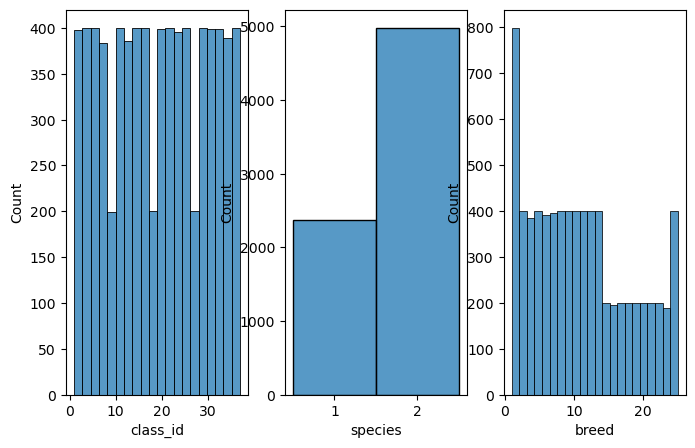

In [8]:
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
sns.histplot(data_annotations['class_id'])

plt.subplot(1, 3, 2)
sns.histplot(data_annotations.species, discrete = True)

plt.subplot(1, 3, 3)
sns.histplot(data_annotations.breed)

plt.show()

In [ ]:
'''
# Sanity check-
for img, annot in tqdm(zip(data_annotations.image, data_annotations.trimap), total = len(data_annotations)):
    Image.open(img).verify()
    Image.open(annot).verify()
'''

In [8]:
# Define different masks-
MASK_FG = 1
MASK_BG = 2
MASK_IGNORE = 3

In [9]:
# Define transforms for data augmentation-
'''
transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(32, padding = 4),
        transforms.Resize((200, 200)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225))
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)
        ),
    ]
)
'''

train_transforms = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), A.VerticalFlip(p = 0.5),
        A.RandomScale(),
        A.Rotate(border_mode = cv2.BORDER_CONSTANT, mask_value = MASK_BG),
        A.RandomBrightnessContrast(p = 0.2),
        A.SmallestMaxSize(224), A.RandomCrop(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(224), A.CenterCrop(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [10]:
class IIITDataset(torch.utils.data.Dataset):
    '''
    Custom PyTorch Dataset class for IIIT Pet dataset.
    '''
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        img = Image.open(self.data.image.iloc[i]).convert('RGB')
        mask = Image.open(self.data.trimap.iloc[i])
        
        # Resize mask (width, height)-
        mask = mask.resize(size = (200, 200))
        
        # Convert to numpy array from PIL.Image-
        img = np.asarray(img)
        mask = np.asarray(mask)
        '''
        if self.transform:
            img = self.transform(img)
        '''
        if self.transform:
            augmented = self.transform(image = img, mask = mask)
            img, mask = augmented["image"], augmented["mask"]
        
        return img, mask
    

In [11]:
# Use Stratified K-Fold to get train and test indices-
'''
Stratified K-Folds cross-validator.
Provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns
stratified folds. The folds are made by preserving the percentage of
samples for each class.
'''
skf = StratifiedKFold(n_splits = 5)
train_idx, val_idx = next(iter(skf.split(data_annotations, data_annotations.class_id)))

In [12]:
# Sanity check-
len(train_idx), len(val_idx)

(5879, 1470)

In [13]:
print(f"train set = {len(train_idx) / len(data_annotations) * 100:.2f}% &"
      f" test set = {len(val_idx) / len(data_annotations) * 100:.2f}%")

train set = 80.00% & test set = 20.00%


In [14]:
# Get train and test datasets-
train_data = data_annotations.iloc[train_idx]
test_data = data_annotations.iloc[val_idx]

In [15]:
# Sanity check-
train_data.shape, test_data.shape

((5879, 7), (1470, 7))

In [16]:
del train_idx, val_idx, skf

In [17]:
# Create training and test datasets using PyTorch defined class-
train_ds = IIITDataset(data = train_data, transform = train_transforms)
test_ds = IIITDataset(data = test_data, transform = test_transforms)

In [18]:
# Define mean and standard-deviation for data denormalizing data-
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [19]:
def imagenet_denorm(x):
    """
    x: array-like with shape (..., H, W, C)
    """
    
    return (x * std) + mean


In [20]:
del train_data, test_data

In [21]:
# Define neural network training hyper-parameters-
num_epochs = 50
batch_size = 32

In [22]:
# There is a bug in IPython where if 'num_workers > 0' 

# Create train and test data loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_ds, batch_size = batch_size,
    shuffle = True, num_workers = 4
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_ds, batch_size = batch_size,
    shuffle = True, num_workers = 4
    )

### Define _U-Net_ architecture

_same_ convolutions are used instead of _valid_ convolutions.

In [23]:
class DoubleConv(nn.Module):
    '''
    Class for one U-Net 'contraction/encoder' block.
    '''
    def __init__(
        self, num_inp_channels,
        num_op_channels
    ):
        super(DoubleConv, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_op_channels = num_op_channels
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_op_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_op_channels)
        self.conv2 = nn.Conv2d(
            in_channels = self.num_op_channels, out_channels = self.num_op_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_op_channels)
        
        self.initialize_weights()
    
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x
        

In [24]:
class UNet(nn.Module):
    # My implementation-
    def __init__(
        self, inp_channels = 3,
        op_channels = 2, features = [64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        
        '''
        self.inp_channels = inp_channels
        self.op_channels = op_channels
        self.features = features
        '''
        self.contraction = nn.ModuleList()
        self.expansion = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # U-Net contraction path/part-
        for feature in features:
            self.contraction.append(
                DoubleConv(num_inp_channels = inp_channels, num_op_channels = feature)
            )
            inp_channels = feature
        
        # U-Net expansion path/part-
        '''
        Instead of using Conv transpose, you could also use a bilinear followed
        by a conv layer, or, nn.Bilinear -> nn.Conv2d. In ProGAN paper, the
        authors find that transpose conv create these artifacts. So,
        bilinear -> conv might be a better and a cheaper option.
        '''
        # Go from bottom to up-
        for feature in reversed(features):
            self.expansion.append(
                nn.ConvTranspose2d(
                    in_channels = feature * 2, out_channels = feature,
                    kernel_size = 2, stride = 2,
                    padding = 0
                )
            )
            self.expansion.append(
                DoubleConv(num_inp_channels = feature * 2, num_op_channels = feature)
            )
        
        self.bottleneck = DoubleConv(num_inp_channels = features[-1], num_op_channels = features[-1] * 2)
        self.final_conv = nn.Conv2d(
            in_channels = features[0], out_channels = op_channels,
            kernel_size = 1, padding = 0
        )
    
    
    def forward(self, x):
        # Python3 list for skip connections between contraction and expansion levels-
        skip_connections = []
        
        for down in self.contraction:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        # Reverse list since in expansion we are going backwards as we are doing
        # concatenation (along channels)-
        skip_connections = skip_connections[::-1]
        
        # Expansion path-
        # Use a step of 2 as we are doing up-conv and DoubleConv which is like a
        # single step here.
        for idx in range(0, len(self.expansion), 2):
            # Do conv transpose 2d (upsampling)-
            x = self.expansion[idx](x)
            
            # Get appropriate skip connection-
            skip_connection = skip_connections[idx // 2]
            
            # If the shapes don't match-
            if x.shape != skip_connection.shape:
                # Cropping or padding can be used, or, resizing-
                x = TF.resize(x, size = skip_connection.shape[2:])
            
            # Concatenate (batch, channels, height, widhth) along channels-
            concat_skip = torch.cat((skip_connection, x), dim = 1)
            
            # Pass through DoubleConv-
            x = self.expansion[idx + 1](concat_skip)
        
        return self.final_conv(x)
        

In [25]:
# Instantiate an instance of U-Net architecture-
model = UNet(
    inp_channels = 3, op_channels = 3,
    features = [64, 128, 256, 512]
)

In [25]:
def count_trainable_params(model):
    # Count number of trainable parameters in 'model'.
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()
    
    return tot_params


In [27]:
print(f"U-Net architecture has {count_trainable_params(model)} params")

U-Net architecture has 31037763 params


### Mult-GPU PyTorch Training

__Data Parallelism__

To use data parallelism with PyTorch, you can use the ```DataParallel``` class. When using this class, you define your GPU IDs and initialize your network using a Module object with a ```DataParallel``` object.

```
parallel_net = nn.DataParallel(model, device_ids = [0,1,2])
```

Once defined, you can perform the standard model training steps just as you would with a standard ```nn.Module``` object. For example:

```

# perform a forward pass-
predictions = parallel_net(inputs) 

# computes a loss function-
loss = loss_function(predictions, labels)

# average GPU-losses and perform a backward pass-
loss.mean().backward()

# Update parameters-
optimizer.step()
```

When using this method, you need to ensure that your data is initially stored on one GPU (the “primary GPU”). You should also place your data parallel object on that same GPU. You can do this using code like the following:

```
input        = input.to(0)
parallel_net = parellel_net.to(0)
```
Then, when you call your object it can split your dataset into batches that are distributed across your defined GPUs. Once the operations are complete, the outputs are aggregated on the primary GPU. 

[Reference](https://www.run.ai/guides/multi-gpu/pytorch-multi-gpu-4-techniques-explained)

In [ ]:
# Use data parallelism, specify GPUs to use-
model = torch.nn.DataParallel(model, device_ids = [0, 1])

# Move to CUDA GPU-
model.to(0)

In [ ]:
'''
# Get a batch of images and masks-
x, x_mask = next(iter(train_loader))

# Move to CUDA GPU-
x = x.to(0)
x_mask = x_mask.to(0)

# x = x.to(device)
# x_mask = x_mask.to(device)

# Sanity check-
x.shape, x_mask.shape
# (torch.Size([32, 3, 224, 224]), torch.Size([32, 224, 224]))

# Get (random) predictions using model-
out = model(x)

# Sanity check-
x_mask.shape, out.shape
# (torch.Size([32, 224, 224]), torch.Size([32, 3, 224, 224]))

del x, x_mask, out
'''

In [ ]:
'''
# Cross-Entropy loss example with class indices-
x_inp = torch.randn(3, 5, requires_grad = True)
y = torch.randn(3).random_(5)

loss_val = classification_loss(x_inp, y.long()).mean()
loss_val.backward()


# Cross-Entropy loss example with class probabilities
y = torch.randn(3, 5)
y = y.softmax(dim = 1)
loss_val = classification_loss(x_inp, y).mean()
loss_val.backward()
'''

### Computing loss for _U-Net_ architecture

- The output of your network should be something like ```NxCxHxW``` and your target ```NxHxW``` where ```N``` is the batch size and ```C``` is the number of classes.
- Note that ```argmax``` is not a differentiable operation!

For example, say, ```C = 2``` for a binary segmentation task. The output of your network is ```Nx2xHxW```. Your idea is to take the argument max of the 2 classes and create your prediction with that information because your target is only ```NxHxW```. The idea is to transform your target into ```Nx2xHxW``` in order to match the output dimension and compute the dice loss without applying any argmax. To transform your target from ```NxHxW``` into ```Nx2xHxW``` you can transform it to a one-hot vector like-

```
# In your case nb_classes = 2-
labels = F.one_hot(labels, num_classes = nb_classes).permute(0,3,1,2).contiguous()
```

```one_hot()``` will put 1 where the class is and 0 otherwise. (you can check the doc, it is more clear than my explanation) The output of ```one_hot()``` is ```NxHxWxC``` so you have to permute to obtain ```NxCxHxW```.

After this transformation on your target, you should be able to compute the Dice Loss. You might also have to make small changes in the forward of your loss.

You will compute the dice loss for every channel ```C```. The final loss could then be calculated as the weighted sum of all the dice loss. Something like: $\sum_{i=1}^{c}\left(w_i \times D_c\right)$. Where ```c = 2``` for this example and $w_i$ is the weight you want to give to _class i_. And $D_c$ is like your (modified) dice loss that is now able to handle one-hot encoded vector.

- [Pytorch discussion](https://discuss.pytorch.org/t/implementation-of-dice-loss/53552/2)
- [GitHub code](https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183)

- If you are dealing with a binary classification use case, a single output channel and ```nn.BCEWithLogitsLoss``` should be working. _Make sure to pass raw logits to the criterion (no sigmoid at the end)_.

- ```nn.CrossEntropyLoss``` is usually applied for multi class classification/segmentation use cases, where you are dealing with more than two classes. In this case, your target should be a ```LongTensor```, should not have the channel dimension, and should contain the class indices in ```[0, nb_classes-1]```.

In case your model has low accuracy, you might try to overfit a small data sample and see if your model and training routine can successfully overfit this sample. If not, then maybe, your model architecture needs troubleshooting/checking.

#### Dice Loss and Coefficient Formula

1. Dice Coefficient: $DC = \frac{2 \cdot \sum \hat{y} \times y}{\sum\hat{y} + y}$
1. Dice Loss: $DL = 1 - DC$

[Reference](https://www.jeremyjordan.me/semantic-segmentation/#fully_convolutional)

In [26]:
def compute_total_loss(pred, target, K = 3, eps = 1e-6):
    '''
    Compute total loss as: classification_loss + dice_loss.
    Computation involves channel last format.
    '''
    # Channel last format-
    pred = pred.permute((0, 2, 3, 1))
    
    # Subtract 1 from all labels to have (0, k-1) range-
    target = target - 1
    
    # One-hot encode mask-
    target = F.one_hot(target.long(), num_classes = K)
    
    # Prediction must sum to 1 over 'K' channels-
    pred = nn.Softmax(dim = 3)(pred)
    
    # Skip batch and class/label axes for computing dice score-
    axes = tuple(range(1, len(pred.shape) - 1))
    
    # Compute Dice Coefficient-
    numerator = 2 * torch.sum(pred * target, dim = axes)
    denominator = torch.sum(torch.square(pred) + torch.square(target), dim = axes)
    
    # Average over classes and batch-size
    dice_loss = 1 - torch.mean((numerator + eps) / (denominator + eps))
    
    
    # Compute per-pixel classification loss-
    classification_loss = nn.CrossEntropyLoss(reduction = 'none')
    class_loss_val = classification_loss(pred, target.float()).mean()
    
    total_loss = dice_loss + class_loss_val
    
    return total_loss, class_loss_val, dice_loss
    

In [ ]:
'''
total_loss, class_loss, dice_loss = compute_total_loss(
    pred = out, target = x_mask,
    K = 3, eps = 1e-6
)
'''

In [ ]:
# total_loss, class_loss, dice_loss

In [ ]:
# del x, x_mask, out, total_loss, class_loss, dice_loss

In [42]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-4)

# optimizer = torch.optim.SGD(parallel_net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [43]:
def train_one_epoch(model, dataloader, train_dataset):
    
    # Place model to device-
    # model.to(device)\
    model.to(0)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    total_loss_epoch = 0.0
    total_dice_loss = 0.0
    total_classification_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        ):
      
        x = data[0]
        x_mask = data[1]
        
        # Push to 'device'-
        # x = x.to(device)
        # x_mask = x_mask.to(device)
        
        # Push to CUDA GPU-
        x = x.to(0)
        x_mask = x_mask.to(0)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        out = model(x)
        
        # Compute losses-
        total_loss, classification_loss, dice_loss = compute_total_loss(
            pred = out, target = x_mask,
            K = 3, eps = 1e-6
        )
        
        # Compute gradients wrt total loss-
        total_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()

        # Update losses-
        total_classification_loss += classification_loss.item() * x_mask.size(0)
        total_dice_loss += dice_loss.item() * x_mask.size(0)
        total_loss_epoch += total_loss.item() * x_mask.size(0)
        
    
    # Compute losses as float values-
    total_train_loss = total_loss_epoch / len(dataloader.dataset)
    train_dice_loss = total_dice_loss / len(dataloader.dataset)
    train_classification_loss = total_classification_loss / len(dataloader.dataset)

    return total_train_loss, train_dice_loss, train_classification_loss
    


In [45]:
def validate_one_epoch(model, dataloader, test_dataset):
    
    # Place model to device-
    # model.to(device)
    model.to(0)
    
    # Enable evaluation mode-
    model.eval()
    
    total_val_loss = 0.0
    val_classification_loss = 0.0
    val_dice_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / dataloader.batch_size)
        ):
            
            x_v = data[0]
            x_mask_v = data[1]
            
            # Push data points to 'device'-
            x_v = x_v.to(0)
            x_mask_v = x_mask_v.to(0)
            
            # Forward propagation-
            out = model(x_v)
            
            # Compute losses-
            total_loss, classification_loss, dice_loss = compute_total_loss(
                pred = out, target = x_mask_v,
                K = 3, eps = 1e-6
            )
            
            # Update losses-
            total_val_loss += total_loss.item() * x_mask_v.size(0)
            val_dice_loss += dice_loss.item() * x_mask_v.size(0)
            val_classification_loss += classification_loss.item() * x_mask_v.size(0)
                    

    # Compute losses as float values-
    total_val_loss_epoch = total_val_loss / len(dataloader.dataset)
    val_dice_coeff_loss_epoch = val_dice_loss / len(dataloader.dataset)
    val_classification_loss_epoch = val_classification_loss / len(dataloader.dataset)
    
    return total_val_loss_epoch, val_dice_coeff_loss_epoch, val_classification_loss_epoch
    

In [ ]:
'''
total_train_loss, train_dice_loss, train_classification_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    train_dataset = train_ds
)
'''

In [ ]:
'''
total_val_loss, val_dice_loss, val_classification_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    test_dataset = test_ds
)
'''

In [ ]:
# total_train_loss, train_dice_loss, train_classification_loss

In [ ]:
# total_val_loss, val_dice_loss, val_classification_loss

In [ ]:
# del total_train_loss, train_dice_loss, train_classification_loss, total_val_loss, val_dice_loss, val_classification_loss

In [50]:
# Python dict to contain training metrics-
train_history = {}

In [51]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3
# loc_patience = 0

In [52]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    total_train_loss, train_dice_loss, train_classification_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        train_dataset = train_ds
    )
    
    # Get validation after 1 epoch-
    total_val_loss, val_dice_loss, val_classification_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        test_dataset = test_ds
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': total_train_loss,
        'val_loss': total_val_loss,
        'train_dice_loss': train_dice_loss,
        'train_classification_loss': train_classification_loss,
        'val_dice_loss': val_dice_loss,
        'val_classification_loss': val_classification_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {total_train_loss:.4f}",
          f", val loss = {total_val_loss:.4f}, dice loss = {train_dice_loss:.4f}"
          f", classification loss = {train_classification_loss:.4f}, val dice loss"
          f" = {val_dice_loss:.4f} & val classification loss = {val_classification_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (total_val_loss < best_val_loss):
    # (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = total_val_loss
        
        # reset 'loc_patience' variable-
        # loc_patience = 0

        print(f"Saving model with lowest total val loss = {total_val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "UNet_IIIT_Pet_best_model.pth")
        
    '''
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''
    

184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.36it/s]                                                         


Epoch = 1; train loss = 398.6517 , val loss = 398.5940, dice loss = 0.4363, classification loss = 398.2154, val dice loss = 0.4193 & val classification loss = 398.1747
Saving model with lowest total val loss = 398.5940



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.35it/s]                                                         


Epoch = 2; train loss = 398.3059 , val loss = 398.3969, dice loss = 0.4194, classification loss = 397.8865, val dice loss = 0.3960 & val classification loss = 398.0009
Saving model with lowest total val loss = 398.3969



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.31it/s]                                                         


Epoch = 3; train loss = 398.0643 , val loss = 397.7297, dice loss = 0.4128, classification loss = 397.6515, val dice loss = 0.3785 & val classification loss = 397.3512
Saving model with lowest total val loss = 397.7297



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.37it/s]                                                         


Epoch = 4; train loss = 397.8377 , val loss = 397.6192, dice loss = 0.4034, classification loss = 397.4343, val dice loss = 0.3628 & val classification loss = 397.2564
Saving model with lowest total val loss = 397.6192



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.29it/s]                                                         


Epoch = 5; train loss = 397.5492 , val loss = 397.4470, dice loss = 0.3961, classification loss = 397.1531, val dice loss = 0.3665 & val classification loss = 397.0805
Saving model with lowest total val loss = 397.4470



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.07it/s]                                                         


Epoch = 6; train loss = 397.4278 , val loss = 397.0679, dice loss = 0.3893, classification loss = 397.0385, val dice loss = 0.3687 & val classification loss = 396.6992
Saving model with lowest total val loss = 397.0679



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.33it/s]                                                         


Epoch = 7; train loss = 397.1251 , val loss = 396.9743, dice loss = 0.3833, classification loss = 396.7419, val dice loss = 0.3586 & val classification loss = 396.6157
Saving model with lowest total val loss = 396.9743



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.10it/s]                                                         


Epoch = 8; train loss = 396.9858 , val loss = 396.6496, dice loss = 0.3788, classification loss = 396.6070, val dice loss = 0.3564 & val classification loss = 396.2933
Saving model with lowest total val loss = 396.6496



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.38it/s]                                                         

Epoch = 9; train loss = 396.9362 , val loss = 396.7955, dice loss = 0.3761, classification loss = 396.5602, val dice loss = 0.3496 & val classification loss = 396.4459



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.34it/s]                                                         


Epoch = 10; train loss = 396.7555 , val loss = 396.2249, dice loss = 0.3698, classification loss = 396.3857, val dice loss = 0.3250 & val classification loss = 395.8999
Saving model with lowest total val loss = 396.2249



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.26it/s]                                                         

Epoch = 11; train loss = 396.5213 , val loss = 396.6061, dice loss = 0.3660, classification loss = 396.1553, val dice loss = 0.3496 & val classification loss = 396.2564



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.22it/s]                                                         


Epoch = 12; train loss = 396.4354 , val loss = 396.0125, dice loss = 0.3623, classification loss = 396.0730, val dice loss = 0.3251 & val classification loss = 395.6874
Saving model with lowest total val loss = 396.0125



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.33it/s]                                                         


Epoch = 13; train loss = 396.3599 , val loss = 395.7977, dice loss = 0.3601, classification loss = 395.9999, val dice loss = 0.3228 & val classification loss = 395.4749
Saving model with lowest total val loss = 395.7977



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.39it/s]                                                         

Epoch = 14; train loss = 396.2824 , val loss = 396.0520, dice loss = 0.3578, classification loss = 395.9245, val dice loss = 0.3208 & val classification loss = 395.7312



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.32it/s]                                                         

Epoch = 15; train loss = 396.1577 , val loss = 395.9323, dice loss = 0.3555, classification loss = 395.8021, val dice loss = 0.3249 & val classification loss = 395.6074



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.44it/s]                                                         


Epoch = 16; train loss = 396.1385 , val loss = 395.5926, dice loss = 0.3544, classification loss = 395.7841, val dice loss = 0.3201 & val classification loss = 395.2725
Saving model with lowest total val loss = 395.5926



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.48it/s]                                                         

Epoch = 17; train loss = 396.0820 , val loss = 396.0290, dice loss = 0.3515, classification loss = 395.7305, val dice loss = 0.3314 & val classification loss = 395.6976



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.31it/s]                                                         

Epoch = 18; train loss = 396.0390 , val loss = 395.7763, dice loss = 0.3508, classification loss = 395.6882, val dice loss = 0.3187 & val classification loss = 395.4576



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.38it/s]                                                         


Epoch = 19; train loss = 395.8420 , val loss = 395.3441, dice loss = 0.3474, classification loss = 395.4946, val dice loss = 0.3081 & val classification loss = 395.0360
Saving model with lowest total val loss = 395.3441



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.28it/s]                                                         

Epoch = 20; train loss = 395.8376 , val loss = 395.4543, dice loss = 0.3464, classification loss = 395.4912, val dice loss = 0.3232 & val classification loss = 395.1311



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.37it/s]                                                         


Epoch = 21; train loss = 395.7839 , val loss = 395.2911, dice loss = 0.3434, classification loss = 395.4405, val dice loss = 0.3034 & val classification loss = 394.9877
Saving model with lowest total val loss = 395.2911



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.37it/s]                                                         

Epoch = 22; train loss = 395.7400 , val loss = 395.3233, dice loss = 0.3433, classification loss = 395.3967, val dice loss = 0.3195 & val classification loss = 395.0038



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.26it/s]                                                         


Epoch = 23; train loss = 395.6932 , val loss = 395.0836, dice loss = 0.3428, classification loss = 395.3504, val dice loss = 0.3076 & val classification loss = 394.7760
Saving model with lowest total val loss = 395.0836



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.35it/s]                                                         


Epoch = 24; train loss = 395.5910 , val loss = 395.0712, dice loss = 0.3413, classification loss = 395.2496, val dice loss = 0.3029 & val classification loss = 394.7683
Saving model with lowest total val loss = 395.0712



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.10it/s]                                                         

Epoch = 25; train loss = 395.5808 , val loss = 395.4228, dice loss = 0.3391, classification loss = 395.2417, val dice loss = 0.3196 & val classification loss = 395.1032



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.42it/s]                                                         

Epoch = 26; train loss = 395.4601 , val loss = 395.2680, dice loss = 0.3365, classification loss = 395.1237, val dice loss = 0.3033 & val classification loss = 394.9647



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.28it/s]                                                         


Epoch = 27; train loss = 395.4823 , val loss = 395.0405, dice loss = 0.3374, classification loss = 395.1449, val dice loss = 0.3132 & val classification loss = 394.7273
Saving model with lowest total val loss = 395.0405



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.40it/s]                                                         

Epoch = 28; train loss = 395.4401 , val loss = 395.1996, dice loss = 0.3357, classification loss = 395.1044, val dice loss = 0.3103 & val classification loss = 394.8893



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.39it/s]                                                         

Epoch = 29; train loss = 395.3638 , val loss = 395.2587, dice loss = 0.3347, classification loss = 395.0291, val dice loss = 0.3074 & val classification loss = 394.9514



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.39it/s]                                                         

Epoch = 30; train loss = 395.3429 , val loss = 395.4176, dice loss = 0.3344, classification loss = 395.0085, val dice loss = 0.3138 & val classification loss = 395.1038



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.36it/s]                                                         

Epoch = 31; train loss = 395.2474 , val loss = 395.2065, dice loss = 0.3311, classification loss = 394.9163, val dice loss = 0.3171 & val classification loss = 394.8894



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.38it/s]                                                         

Epoch = 32; train loss = 395.2629 , val loss = 395.2591, dice loss = 0.3314, classification loss = 394.9316, val dice loss = 0.3220 & val classification loss = 394.9371



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.36it/s]                                                         

Epoch = 33; train loss = 395.2312 , val loss = 395.1600, dice loss = 0.3308, classification loss = 394.9004, val dice loss = 0.3145 & val classification loss = 394.8456



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.40it/s]                                                         


Epoch = 34; train loss = 395.1377 , val loss = 394.9601, dice loss = 0.3284, classification loss = 394.8093, val dice loss = 0.3043 & val classification loss = 394.6558
Saving model with lowest total val loss = 394.9601



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.40it/s]                                                         


Epoch = 35; train loss = 395.1383 , val loss = 394.8821, dice loss = 0.3276, classification loss = 394.8106, val dice loss = 0.3015 & val classification loss = 394.5806
Saving model with lowest total val loss = 394.8821



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.37it/s]                                                         

Epoch = 36; train loss = 394.9889 , val loss = 394.9314, dice loss = 0.3250, classification loss = 394.6639, val dice loss = 0.3109 & val classification loss = 394.6205



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.37it/s]                                                         


Epoch = 37; train loss = 394.9525 , val loss = 394.7925, dice loss = 0.3246, classification loss = 394.6279, val dice loss = 0.3039 & val classification loss = 394.4885
Saving model with lowest total val loss = 394.7925



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.36it/s]                                                         

Epoch = 38; train loss = 395.0334 , val loss = 394.8116, dice loss = 0.3254, classification loss = 394.7080, val dice loss = 0.2973 & val classification loss = 394.5143



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.31it/s]                                                         

Epoch = 39; train loss = 394.9665 , val loss = 394.9882, dice loss = 0.3231, classification loss = 394.6434, val dice loss = 0.2875 & val classification loss = 394.7007



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.26it/s]                                                         


Epoch = 40; train loss = 394.9713 , val loss = 394.7771, dice loss = 0.3234, classification loss = 394.6479, val dice loss = 0.2921 & val classification loss = 394.4849
Saving model with lowest total val loss = 394.7771



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.30it/s]                                                         


Epoch = 41; train loss = 394.8654 , val loss = 394.7478, dice loss = 0.3212, classification loss = 394.5442, val dice loss = 0.2960 & val classification loss = 394.4519
Saving model with lowest total val loss = 394.7478



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.37it/s]                                                         


Epoch = 42; train loss = 394.8495 , val loss = 394.6251, dice loss = 0.3204, classification loss = 394.5291, val dice loss = 0.2898 & val classification loss = 394.3353
Saving model with lowest total val loss = 394.6251



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.34it/s]                                                         


Epoch = 43; train loss = 394.7781 , val loss = 394.5950, dice loss = 0.3204, classification loss = 394.4576, val dice loss = 0.2985 & val classification loss = 394.2965
Saving model with lowest total val loss = 394.5950



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.37it/s]                                                         

Epoch = 44; train loss = 394.8938 , val loss = 394.6149, dice loss = 0.3198, classification loss = 394.5741, val dice loss = 0.2869 & val classification loss = 394.3280



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.35it/s]                                                         

Epoch = 45; train loss = 394.7894 , val loss = 394.6468, dice loss = 0.3178, classification loss = 394.4716, val dice loss = 0.2853 & val classification loss = 394.3615



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.37it/s]                                                         


Epoch = 46; train loss = 394.7316 , val loss = 394.5019, dice loss = 0.3169, classification loss = 394.4147, val dice loss = 0.2864 & val classification loss = 394.2155
Saving model with lowest total val loss = 394.5019



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.39it/s]                                                         

Epoch = 47; train loss = 394.6496 , val loss = 394.6611, dice loss = 0.3151, classification loss = 394.3345, val dice loss = 0.2951 & val classification loss = 394.3660



184it [01:07,  2.73it/s]                                                        
46it [00:06,  7.35it/s]                                                         

Epoch = 48; train loss = 394.6170 , val loss = 394.5881, dice loss = 0.3140, classification loss = 394.3030, val dice loss = 0.3091 & val classification loss = 394.2791



184it [01:07,  2.72it/s]                                                        
46it [00:06,  7.34it/s]                                                         

Epoch = 49; train loss = 394.6097 , val loss = 394.6042, dice loss = 0.3139, classification loss = 394.2958, val dice loss = 0.2971 & val classification loss = 394.3071



184it [01:07,  2.74it/s]                                                        
46it [00:06,  7.34it/s]                                                         

Epoch = 50; train loss = 394.6521 , val loss = 394.6281, dice loss = 0.3142, classification loss = 394.3379, val dice loss = 0.2936 & val classification loss = 394.3345


In [35]:
# torch.save(model.state_dict(), "UNet_IIIT_Pet_last_epoch_model.pth")

In [53]:
# Save training history as pickle file-
with open("UNet_IIIT_Pet_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [32]:
'''
# Load training history from pickle file-
with open("UNet_IIIT_Pet_training_history.pkl", "rb") as file:
    train_history = pickle.load(file)
'''

#### Loss Visualizations

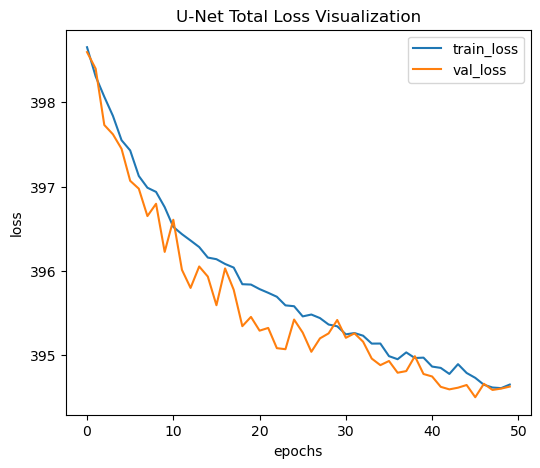

In [36]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("U-Net Total Loss Visualization")
plt.show()

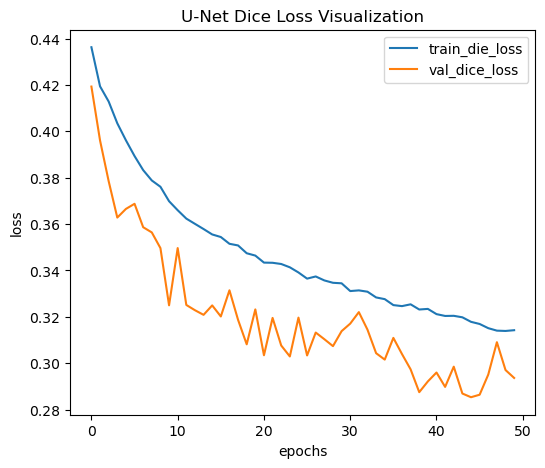

In [35]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_dice_loss'] for e in train_history.keys()], label = 'train_die_loss')
plt.plot([train_history[e]['val_dice_loss'] for e in train_history.keys()], label = 'val_dice_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("U-Net Dice Loss Visualization")
plt.show()

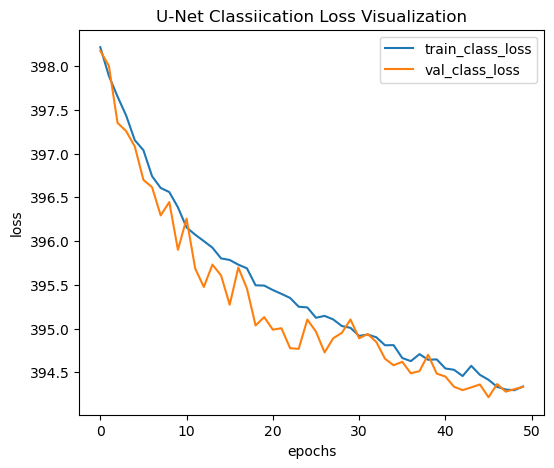

In [37]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_classification_loss'] for e in train_history.keys()], label = 'train_class_loss')
plt.plot([train_history[e]['val_classification_loss'] for e in train_history.keys()], label = 'val_class_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("U-Net Classiication Loss Visualization")
plt.show()

In [ ]:
# Initialize a U-Net model, load 'best' parameters-
trained_model = UNet(
    inp_channels = 3, op_channels = 3,
    features = [64, 128, 256, 512]
)

# Use data parallelism, specify GPUs to use-
trained_model = torch.nn.DataParallel(trained_model, device_ids = [0, 1])

# Move to CUDA GPU-
trained_model.to(0)

In [42]:
# Load 'best' trained parameters-
trained_model.load_state_dict(torch.load('UNet_IIIT_Pet_best_model.pth'))

<All keys matched successfully>

In [69]:
print(f"U-Net model has {count_trainable_params(model = trained_model)} parameters")

U-Net model has 31037763 parameters


In [47]:
# Get a batch of validation/testing images and masks-
x, x_mask = next(iter(test_loader))

# Push to device-
x = x.to(0)
x_mask = x_mask.to(0)
# trained_parallel_net = parallel_net.to(0)

# Get forward propagation-
preds = trained_model(x)

In [48]:
preds.shape, x_mask.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 224, 224]))

In [49]:
# Do for image, output and mask-
x = torch.permute(input = x, dims = (0, 2, 3, 1))
x = x.cpu().detach().numpy()

preds = torch.permute(input = preds, dims = (0, 2, 3, 1))
preds = preds.cpu().detach().numpy()

x_mask = torch.permute(input = x_mask, dims = (0, 1, 2))
x_mask = x_mask.cpu().detach().numpy()

In [51]:
# Sanity check-
x.shape, x_mask.shape, preds.shape

((32, 224, 224, 3), (32, 224, 224), (32, 224, 224, 3))

In [52]:
# Denormalize image-
x = imagenet_denorm(x)
x.shape

(32, 224, 224, 3)

In [53]:
# Use argmax to get pixel-wise K-way classification label-
preds = np.argmax(a = preds, axis = -1)

In [55]:
preds.shape

(32, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


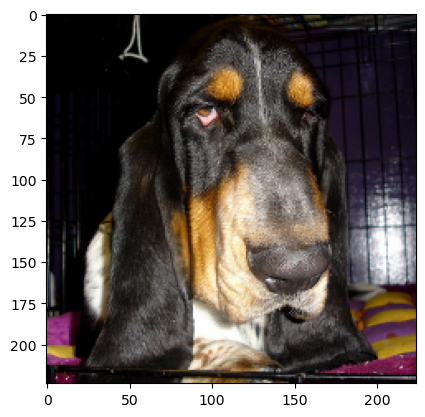

In [56]:
plt.imshow(x[10])
plt.show()

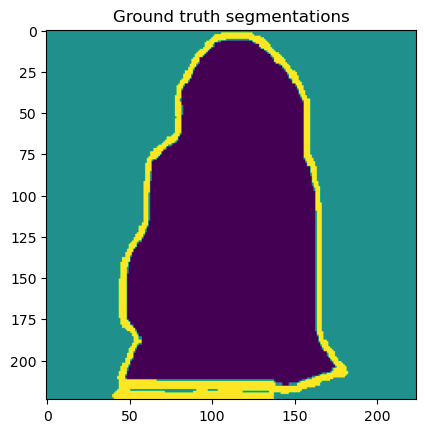

In [57]:
plt.imshow(x_mask[10])
plt.title("Ground truth segmentations")
plt.show()

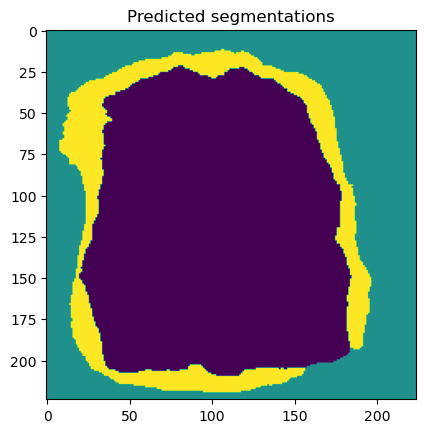

In [59]:
plt.imshow(preds[10])
plt.title("Predicted segmentations")
plt.show()

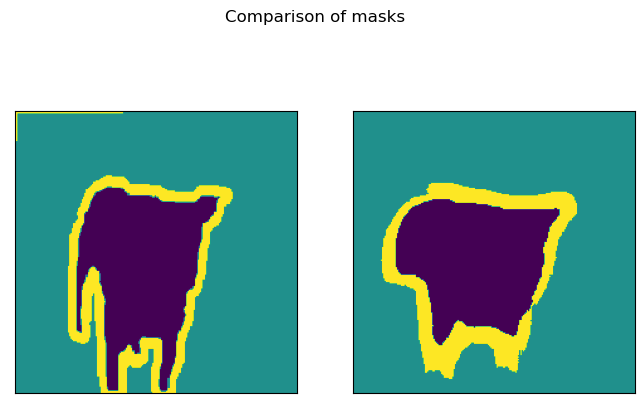

In [61]:
# Visualize image and its corresponding mask-
plt.figure(figsize = (8, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_mask[5])
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(preds[5])
plt.xticks([])
plt.yticks([])

plt.suptitle("Comparison of masks")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

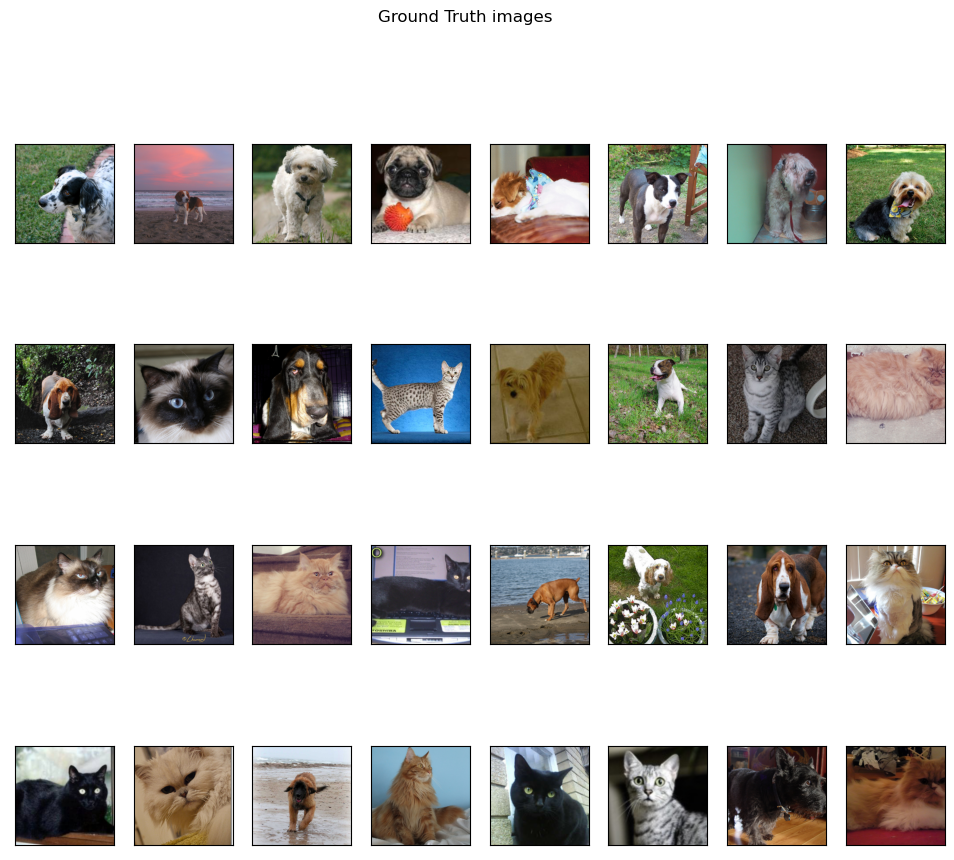

In [67]:
# Visualize images from training set-
plt.figure(figsize = (12, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Ground Truth images")
plt.show()

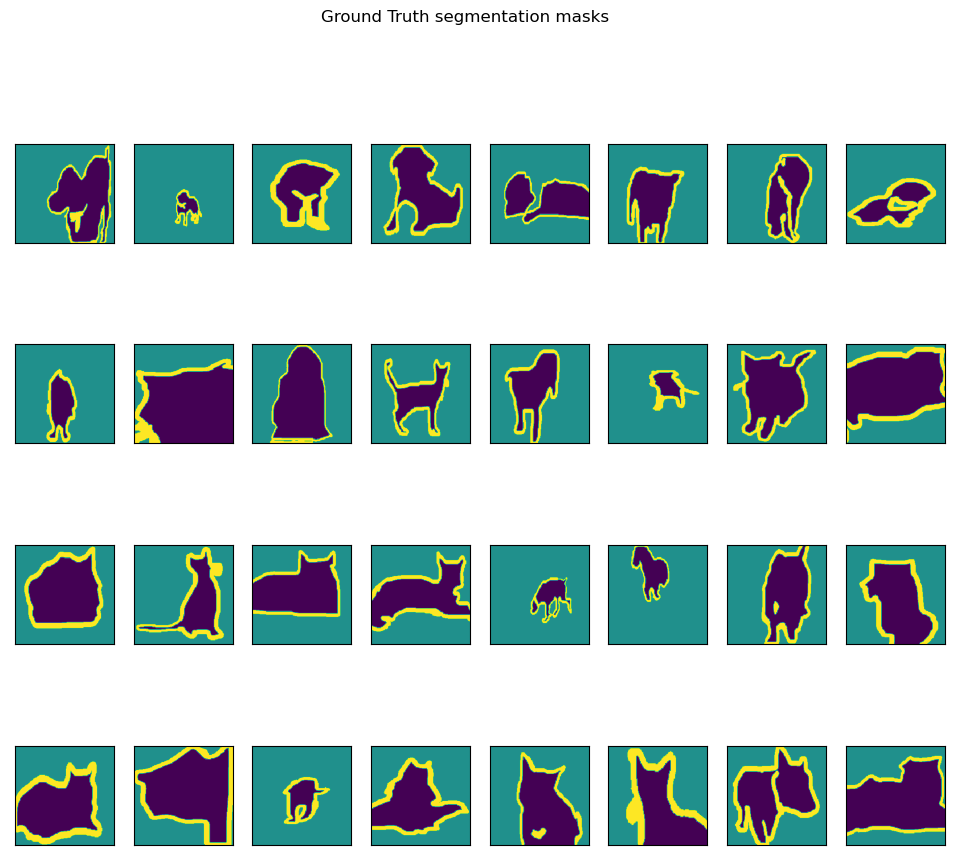

In [65]:
# Visualize images from training set-
plt.figure(figsize = (12, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(x_mask[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Ground Truth segmentation masks")
plt.show()

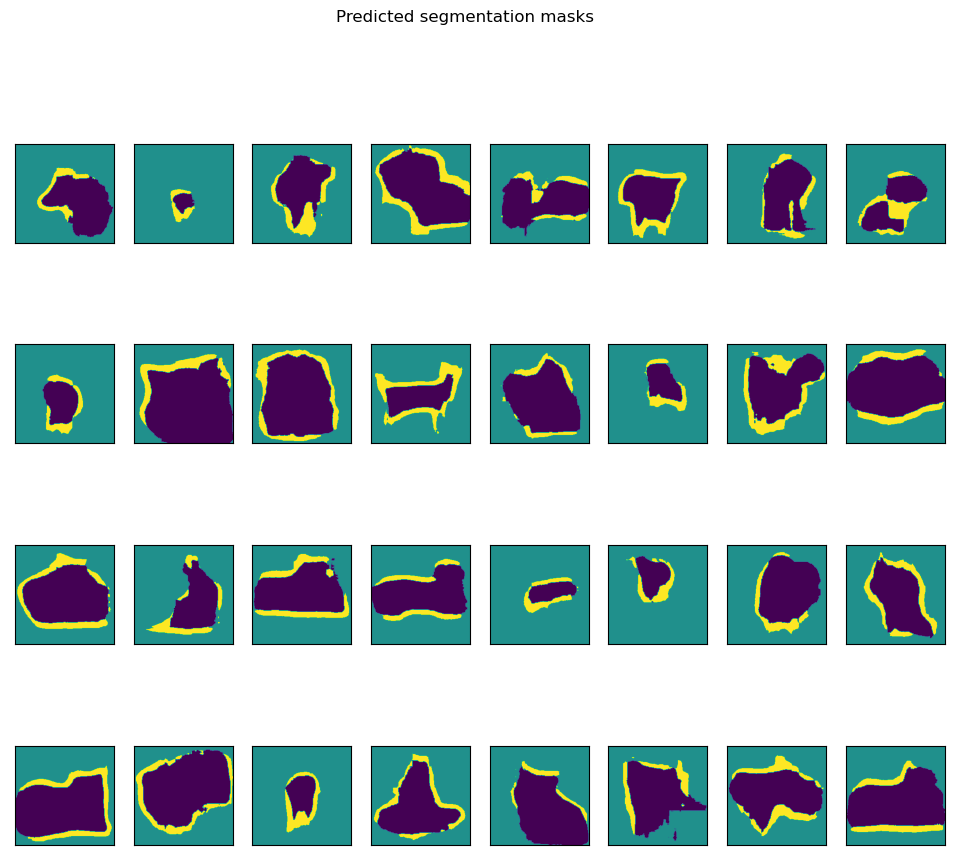

In [66]:
# Visualize images from training set-
plt.figure(figsize = (12, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(preds[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Predicted segmentation masks")
plt.show()

#### To Do:

The loss doesn't seem to have converged. Needs more training.